# Movie recommendation System

We'll use the tmdb-5000 data which contains the following files.
* credits.csv contains cast, crew, and movieId
* movies.csv contains many columns some of which are noted below,
    * genre - genre of the movie,
    * overview - A brief description of the movie
    * tagline - Movie's tagline
    * title - Title of the movie
    * vote_average - average ratings the movie recieved
    * vote_count - the count of votes recieved
    * keywords - The keywords or tags related to the movie, etc

<p style="font-size:15px">The main reason for selecting this dataset was its small size and the text-based movie description data that it contains </p>

In [85]:
import pandas as pd 
import numpy as np 


In [86]:
df1=pd.read_csv('tmdb_5000/tmdb_5000_credits.csv')
df2=pd.read_csv('tmdb_5000/tmdb_5000_movies.csv')

In [87]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

In [88]:
type((df2).genres[1])

str

## Base model  
<p style="font-size:15px">For this, we'll make recommendations based on mean ratings and return the best rated  movies to the user. But since mean ratings do not ideally incorperate the weight of a movie's popularity, we'll use bayesian ratings instead by taking into account the number of ratings too. </p>


We can use imdb's weighted rating formula for this: <br><br>
$Weighted Rating, (W_{R}) = (\frac{v}{v+m}.R) +  (\frac{m}{v+m}.C)  $
<br>
where,

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

In [89]:
C = df2['vote_average'].mean()
C

6.092171559442016

In [90]:
# taking only top 90% movies
m = df2['vote_count'].quantile(0.9)
print(m)
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape                                                  # 481 movies remain in dataset

1838.4000000000015


(481, 23)

In [91]:
# function that reeturns bayesian/weighted ratings
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [92]:
# now we add this as a column to selected movies
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

<p style="font-size:15px">Now we have our first base model that will return the top 10 movies based on weighted ratings </p>

In [93]:
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 10 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


<p style="font-size:15px">And one which returns the most popular movies</p>  

Text(0.5, 1.0, 'Popular Movies')

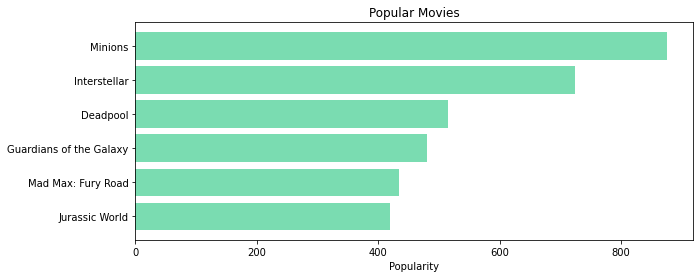

In [94]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='#7ADCB1')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


## Content based filtering

### Description based - 

<p style="font-size:15px">Here I will use content of the movie overview to find similar movies </p>

In [95]:
# overvie col contains desrciption of the movie
df2.overview.head()                             

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

<p style="font-size:15px">  To vectorize this text information I will use the TF*IDF vectorizer for each movie. tf-idf returns a matrix containing movies vs words and the values are the importance of each word in that movie. This is done in such a way that unique words are given more importance, ie if a word appears many times in a movie but it is also present in many documents then its importance will be less.</p>

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')                           # Define a tf-idf vectorizer object. remove common words like 'the', 'and',..
df2['overview'] = df2['overview'].fillna('')                            # Replace NaN with an empty string
tfidf_matrix = tfidf.fit_transform(df2['overview'])                     # Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix.shape

(4803, 20978)

<p style="font-size:15px"> The number of columns represents the different words. So we have around 21000 total words.<br>
Now we can calculate the similarity bewtween these words using thie tfidf-matrix. This can be done using cosine similarity,
but since we already have vectorized the words, we can just take their dot product instead to get the cosine similarity.
 <br></p>

<p style="font-size:15px">That will be done using linear_kernel which returns for transpose(X).Y</p>

In [97]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)      

<p style="font-size:15px"> Now I will define a function to return top similar movies</p>

In [98]:
# create a title vs movieId series
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates() 

# Function that takes in movie title as input and outputs most similar movies based on a similarity matrix
def get_recommendations(title, cosine_sim=cosine_sim):

    index = indices[title]

    # get enumerated list of similarity scores of all movies with that movie and sort it, 
    # the return top 10 movies (except itself)
    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    return df2['title'].iloc[movie_indices]           

In [99]:
get_recommendations('Batman Begins')
get_recommendations('Inception')
get_recommendations('Avatar')

3604                       Apollo 18
2130                    The American
634                       The Matrix
1341            The Inhabited Island
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: title, dtype: object

<p style="font-size:15px"> The results are dectent but since we based the similarity on plot description, only movies with similar story content are returned. This could form a part of the agregate reccomendations but is not the ideal final result for a full-fledged recommender system. </p>

### Cast,crew and genre based - 

<p style="font-size:15px"> Firstly since the required data (cast, crew, keywords & genre) is present as string, we need to convert it to valid datatype. I'll be using literal_eval fro ast library to do so. </p>

In [100]:
# ast. literal_eval raises an exception if the input isn't a valid Python datatype, so the code won't be executed if it's not.
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [ ]:
# type((df2).genres[1]), df2

In [102]:
# Get the director's name from the crew feature from credits data
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [103]:
# returns top 3 elements from list or entire list, whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list if item is not list
    return []

In [104]:
# Define new director, cast, genres and keywords features in usable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)             # only top 3 items remain


In [105]:
df2[['title', 'cast', 'director', 'keywords', 'genres']].head()

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"
3,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman]",Christopher Nolan,"[dc comics, crime fighter, terrorist]","[Action, Crime, Drama]"
4,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",Andrew Stanton,"[based on novel, mars, medallion]","[Action, Adventure, Science Fiction]"


<p style="font-size:15px"> Now I'll join all the strings in these columnns to get one soup-string which we'll feed into a text vectorizer which will return me the importance of these words (here cast,genre.. info) in each movie. <br>
And this time I'll use Count-Vectorizer instead of TF-IDF because tf-idf down-weights the presence of same words in differernt documents, but this time we dont want to do that. For example we dont want to reduce importance of a actor if he has appeared in many movies. <br>
 <br>But first I'll have to convert the cast crew names into one-word lowercased string for each instance. </p>
 

In [106]:
def clean_data(x):
    # if item is list, like in cast and keywords then clean for each item
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]                  
    else:
    # if its string -
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [107]:
# apply clean_data function to the features
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [124]:
# create string-soup for each movie 
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

In [118]:
# now use count-vectorizer
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [119]:
# find similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [120]:
df2

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,status,tagline,title,vote_average,vote_count,tittle,cast,crew,director,soup
0,0,237000000,"[action, adventure, fantasy]",http://www.avatarmovie.com/,19995,"[cultureclash, future, spacewar]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[samworthington, zoesaldana, sigourneyweaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",jamescameron,cultureclash future spacewar samworthington zo...
1,1,300000000,"[adventure, fantasy, action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drugabuse, exoticisland]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",goreverbinski,ocean drugabuse exoticisland johnnydepp orland...
2,2,245000000,"[action, adventure, crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, basedonnovel, secretagent]",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[danielcraig, christophwaltz, léaseydoux]","[{'credit_id': '54805967c3a36829b5002c41', 'de...",sammendes,spy basedonnovel secretagent danielcraig chris...
3,3,250000000,"[action, crime, drama]",http://www.thedarkknightrises.com/,49026,"[dccomics, crimefighter, terrorist]",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[christianbale, michaelcaine, garyoldman]","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",christophernolan,dccomics crimefighter terrorist christianbale ...
4,4,260000000,"[action, adventure, sciencefiction]",http://movies.disney.com/john-carter,49529,"[basedonnovel, mars, medallion]",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[taylorkitsch, lynncollins, samanthamorton]","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",andrewstanton,basedonnovel mars medallion taylorkitsch lynnc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,4798,220000,"[action, crime, thriller]",NaN,9367,"[unitedstates–mexicobarrier, legs, arms]",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,...,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,El Mariachi,"[carlosgallardo, jaimedehoyos, petermarquardt]","[{'credit_id': '52fe44eec3a36847f80b280b', 'de...",robertrodriguez,unitedstates–mexicobarrier legs arms carlosgal...
4799,4799,9000,"[comedy, romance]",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,...,Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,Newlyweds,"[edwardburns, kerrybishé, marshadietlein]","[{'credit_id': '52fe487dc3a368484e0fb013', 'de...",edwardburns,edwardburns kerrybishé marshadietlein edwardb...
4800,4800,0,"[comedy, drama, romance]",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[date, loveatfirstsight, narration]",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,...,Released,NaN,"Signed, Sealed, Delivered",7.0,6,"Signed, Sealed, Delivered","[ericmabius, kristinbooth, crystallowe]","[{'credit_id': '52fe4df3c3a36847f8275ecf', 'de...",scottsmith,date loveatfirstsight narration ericmabius kri...
4801,4801,0,[],http://shanghaicalling.com/,126186,[],en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,...,Released,A New Yorker in Shanghai,Shanghai Calling,5.

In [121]:
# title vs movieId series 
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [128]:
# Now I'll use the get_recommendations function i built earlier to get recommendations based on the 2nd similarity matrix
get_recommendations('Batman Begins', cosine_sim2)
get_recommendations('Pulp Fiction', cosine_sim2)

830              Kill Bill: Vol. 2
574                       S.W.A.T.
684              The Hateful Eight
1156                A Time to Kill
2124              Lakeview Terrace
2822                  Jackie Brown
1253                 Kiss of Death
2723       The Caveman's Valentine
4300                Reservoir Dogs
283     The Taking of Pelham 1 2 3
Name: title, dtype: object